In [3]:
# PPC. Written by Sabina Nowakowska, edited by Revan Rangotis

# Import needed packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import hddm
import kabuki
import numpy as np
import math
from scipy.stats import norm
import os
import pymc
import seaborn as sns
import colorsys as cs
import re

Modify the cell below to control how the plots look and low they are labelled

In [4]:
list_models = ['humans_cylinder_buttons_z_5percent_outlier_removal1','humans_cylinder_saccades_z_5percent_outlier_removal1','humans_dots_buttons_z_5percent_outlier_removal1','humans_dots_saccades_z_5percent_outlier_removal1','m133_cyl_z_5percent_outlier_removal1','m134_cyl_z_5percent_outlier_removal1','m133_RDK_z_5percent_outlier_removal1','m134_RDK_z_5percent_outlier_removal1']
list_sbj = ['Humans','Humans','Humans','Humans','m133','m134','m133','m134'] # list of the subject/species names (must correspond to the list of the models above)
list_model_name = ['cylinder_buttons_z_5percent_outlier_removal1','cylinder_saccades_z_5percent_outlier_removal1','dots_buttons_z_5percent_outlier_removal1','dots_saccades_z_5percent_outlier_removal1','cyl_z_5percent_outlier_removal1','cyl_z_5percent_outlier_removal1','RDK_z_5percent_outlier_removal1','RDK_z_5percent_outlier_removal1'] # list of model names that will be displayed on graphs or in file names (must correspond with the list of models above)
list_task = ['Cyl','Cyl','RDK','RDK','Cyl','Cyl','RDK','RDK'] # list of task names (must correspond with the list of models above)
list_modes = ['hand','sac','hand','sac','sac','sac','hand','hand'] # list of response modes (must correspond with the list of models above)

# Thresholds of the participants and monkeys 
psychometric_thresholds = [0.011, 0.01, 11.8, 13.6, 0.026, 0.02, 24.7, 12.3]

palettes = [(0, 0.012, 0.769),(0.275, 0.016, 0.588),(0.612, 0.016, 0.573),(0.741, 0, 0),(0.878, 0.365, 0),(0.949, 0.792, 0),(0, 0.859, 0.027),(0.18, 0.541, 0.478)]
min_trials=10 # minimum number of trials per stimulus to be included in the PPC plots
min_sessions=0.4 # minimum number of sessions per stimulus to be included in the PPC plots
ncols = 4 # number of columns for the PPC subplots (depends on the number of the stimuli and how big you want the plots to be)
range_=(-6, 6) # reaction time boundaries for the simulation ()
samples = 100 # number of samples from the parameter distribution (ie. how many times do you want to run the simulation?)
quantiles = (.2, .4, .6, .8) # quantiles that should be included in the PPC quantile plots
min_bin = -3 # maximum reaction time for the false respones to be displayed in a histogram (in seconds; needs to be < 0, as negative sign s what distinguishes RTs for false responses from correct responses)
max_bin = 3 # maximum reaction time for the correct respones to be displayed in a histogram (in seconds)
bin_size = 0.1 # size of the bin for the reaction times histograms (in seconds)
fs_title = 18 # fontsize for the plot titles
fs_ticks = 14 # fontsize for axes labels in the plots
fs_labels = 16 # fontsize for big labels in the plots (eg. overall label)
fs_subtitles = 16 # fontsize for the titles of subplots
alpha_val = 0.5 # alpha (transparency) value for the confidnece intervals etc.
xlim_cyl_monkeys = (-0.04, 0.04)
xlim_cyl = (-0.09, 0.09)
xlim_RDK = (-60, 60)

Define some functions for plotting

In [5]:
def identify_stimuli_with_few_trials(data, min_trials):
    stim_to_remove_left = []
    stim_to_remove_right = []
    stimuli = data.stim.unique()
    for stimulus in stimuli:
        temp_resps = data.loc[data.stim == stimulus, "response"]

        # For negative stimuli (should go left)
        if np.sign(stimulus) > 0:
            if len(temp_resps[temp_resps == 0]) < min_trials:
                stim_to_remove_left.append(stimulus)

        else:
            if len(temp_resps[temp_resps == 1]) < min_trials:
                stim_to_remove_right.append(stimulus)
    return stim_to_remove_left, stim_to_remove_right

In [6]:
def simulate_ppc(data,model,samples,quantiles,stimuli):
    
    # Initiate dataframe to store all the rts
    sim_data_all = pd.DataFrame()
    
    quantiles_data_left = {}
    quantiles_data_right = {}
    
    for j,stim in enumerate(stimuli):
        
        # Generate an empty dataframe to store the quantiles from each sample
        qs_left = np.zeros([len(quantiles), samples])
        qs_right = np.zeros([len(quantiles), samples])

        # Simulate the data
        for i in range(samples):

            # Select parameters randomly from the trace
            traces = model.get_group_traces()
            ind = np.random.randint(len(traces)-1)
            rand_params = traces.loc[ind]
            
            sz = 0
            sv = 0
            st = 0

            v = rand_params['v_stim']*stim+rand_params['v_Intercept']

            # How many trials for a given stimulus were performed
            size = np.sum(data['stim']==stim)

            rts = hddm.wfpt.gen_rts_from_cdf(v, sv, rand_params['a'], pymc.invlogit(rand_params['z_trans']),
                                             sz, rand_params['t'], st, size, range_[0], range_[1], 0.001)
            sim_data = pd.DataFrame(rts, columns=['rt'])
            
            # Associate negative rts with response 0 and positive with response 1
            sim_data['response'] = 1
            sim_data.loc[sim_data['rt'] < 0,'response'] = 0

            sim_data['sample'] = i
            sim_data['stimulus'] = stim
            sim_data.loc[((sim_data['stimulus'] < 0) & (sim_data['response']==0)) | ((sim_data['stimulus'] > 0) & (sim_data['response']==1)), 'accuracy'] = 1
            sim_data.loc[((sim_data['stimulus'] < 0) & (sim_data['response']==1)) | ((sim_data['stimulus'] > 0) & (sim_data['response']==0)), 'accuracy'] = 0

            sim_data_all = sim_data_all.append(sim_data)            
            
            # Compute quantiles for a sample and store in the dataframe
            q_left = abs(sim_data.rt[sim_data['response']==0]).quantile(q=quantiles)
            q_right = abs(sim_data.rt[sim_data['response']==1]).quantile(q=quantiles)
            qs_left[:,i]=q_left
            qs_right[:,i]=q_right

            # Store proportion of right answers.
            props_right[i,j] = sum(sim_data['response']==1)/len(sim_data['rt'])

            # Get the mean RTs

            # correct
            rts_corr[i,j] = sim_data[sim_data['accuracy']==1].rt.abs().mean()
            if stim == 0:
                rts_corr[i,j] = sim_data.rt.abs().mean()

            # false
            rts_false[i,j] = sim_data[sim_data['accuracy']==0].rt.abs().mean()
            if stim == 0:
                rts_false[i,j] = sim_data.rt.abs().mean()

            # all
            rts_all[i,j] = sim_data.rt.abs().mean()
            
        quantiles_data_left[stim] = qs_left
        quantiles_data_right[stim] = qs_right

    return sim_data_all, quantiles_data_left, quantiles_data_right, rts_corr, rts_false, rts_all

In [7]:
def x_ticks_cylinder(x, pos):
    # a function to change display of xTicks
    if x == 0:
        return '0'
    else:
        return '{:.2f}'.format(x)

### Posterior predictive check ###

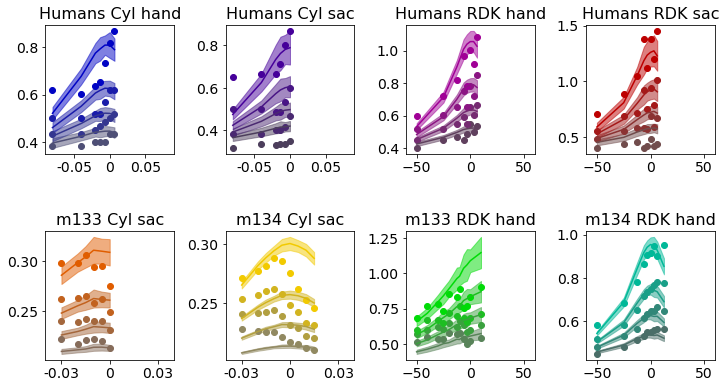

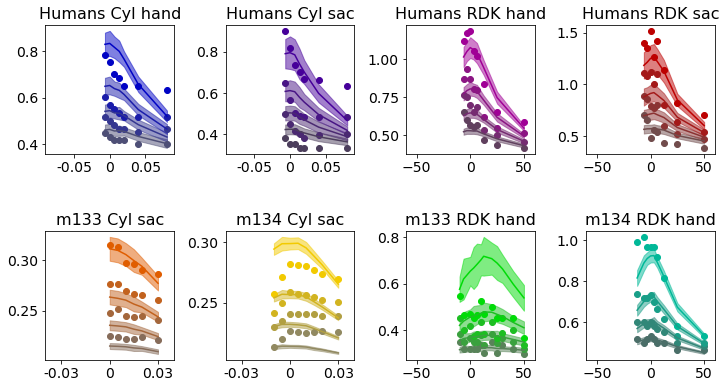

In [8]:
# Initiate figures
# Quantiles for left responses
fig_qs_left = plt.figure(figsize=(12,6))
fig_qs_left.subplots_adjust(top=0.9, hspace=.6, wspace=.4)

# Quantiles for right responses
fig_qs_right = plt.figure(figsize=(12,6))
fig_qs_right.subplots_adjust(top=0.9, hspace=.6, wspace=.4)

# Iterate over the models 
for i in range(len(list_models)):
    model = hddm.load(list_models[i])
    monkey = list_sbj[i]
    model_name = list_model_name[i]
    task = list_task[i]
    palette = palettes[i]
    mode = list_modes[i]
    
    data = model.data
    data.rename(columns={'acc':'accuracy'}, inplace=True) # make sure accuracy table is called "accuracy"
    
    # setup colours for plots
    h, l, s = cs.rgb_to_hls(*palette)
    sat_vals = np.linspace(0.2,1,len(quantiles))
    shades = []
    for sat_val in sat_vals:
        shades.append(cs.hls_to_rgb(h, l, sat_val))
    colour = shades[-1]
    
    # Assign the appropriate number of trials to do the PPC on, since too few result in poor simulations
    
    # There were particularly few trials for the RDK for the monkeys 
    if model_name == "RDK_z_5percent_outlier_removal1":
        min_trials = 60

    elif model_name == "cyl_z_5percent_outlier_removal1":
        min_trials = 400
        
    else:
        min_trials = 250
    
    [stim_to_remove_left, stim_to_remove_right] = identify_stimuli_with_few_trials(data, min_trials)
    
    # Split data to left and right responses
    indices_to_remove_left = data[data['stim'].isin(stim_to_remove_left)].index
    indices_to_remove_right = data[data['stim'].isin(stim_to_remove_right)].index
    left_resp = data.loc[~data.index.isin(indices_to_remove_left)]
    left_resp = left_resp[left_resp['response']==0]
    right_resp = data.loc[~data.index.isin(indices_to_remove_right)]
    right_resp = right_resp[right_resp['response']==1]
    
    # Compute the quantiles
    left_RT_flip = -left_resp.rt
    left_q = left_RT_flip.groupby(left_resp.stim).quantile(q=quantiles)
    right_q = right_resp.rt.groupby(right_resp.stim).quantile(q=quantiles)
    # Find the unique stimuli and how many observations for each
    stimuli = data.stim.unique()
    stimuli.sort()
    stim_counts = [list(data['stim']).count(stimulus) for stimulus in stimuli]
    stimuli_left = left_resp.stim.unique()
    stimuli_left.sort()
    stimuli_right = right_resp.stim.unique()
    stimuli_right.sort()
    
    # Obtain the parameters of posterior distribution
    params=model.gen_stats()

    # Define some empty arrays
    qs_mean_left = np.zeros([len(quantiles), len(stimuli)])
    qs_std_left = np.zeros([len(quantiles), len(stimuli)])
    qs_mean_right = np.zeros([len(quantiles), len(stimuli)])
    qs_std_right = np.zeros([len(quantiles), len(stimuli)])
    props_right = np.zeros([samples+2, len(stimuli)])
    props_left = np.zeros([samples+2, len(stimuli)])
    rts_corr = np.zeros([samples+2, len(stimuli)])
    rts_false = np.zeros([samples+2, len(stimuli)])
    rts_all = np.zeros([samples+2, len(stimuli)])

    # Flip the sign of lower bound rts
    flip_data=hddm.utils.flip_errors(data)

    # Simulation
    [sim_data_all, qs_left, qs_right, rts_corr, rts_false, rts_all] = simulate_ppc(data,model,samples,quantiles,stimuli)
        
    # Get mean and std for each quantile and stimulus
    qs_stim_right = list(qs_right.keys())
    for j,k in enumerate(qs_stim_right):
        qs_mean_right[:,j] = np.nanmean(qs_right[k],axis=1)
        qs_std_right[:,j] = np.nanstd(qs_right[k],axis=1)
    
    qs_stim_left = list(qs_left.keys())
    for j,k in enumerate(qs_stim_left):
        qs_mean_left[:,j] = np.nanmean(qs_left[k],axis=1)
        qs_std_left[:,j] = np.nanstd(qs_left[k],axis=1)

    
    # Quantile plots 
    # Define z for computing confidence intervals
    z = norm.ppf(0.95)    
    ax_qs_left = fig_qs_left.add_subplot(2, 4, i+1)
    ax_qs_right = fig_qs_right.add_subplot(2, 4, i+1)
    
    # Plot predicted quantiles as a line
    for k in range(len(quantiles)):
        idx_to_plot_left = np.isin(stimuli,stimuli_left)
        ax_qs_left.plot(stimuli_left*psychometric_thresholds[i], qs_mean_left[k][idx_to_plot_left],color=shades[k])
        error_left = z*qs_std_left[k]/math.sqrt(samples)
        ax_qs_left.fill_between(stimuli_left*psychometric_thresholds[i], qs_mean_left[k][idx_to_plot_left]-qs_std_left[k][idx_to_plot_left], qs_mean_left[k][idx_to_plot_left]+qs_std_left[k][idx_to_plot_left], alpha=alpha_val, color=shades[k])
         
        idx_to_plot_right = np.isin(stimuli,stimuli_right)
        ax_qs_right.plot(stimuli_right*psychometric_thresholds[i], qs_mean_right[k][idx_to_plot_right],color=shades[k])
        error_right = z*qs_std_right[k]/math.sqrt(samples)
        ax_qs_right.fill_between(stimuli_right*psychometric_thresholds[i], qs_mean_right[k][idx_to_plot_right]-qs_std_right[k][idx_to_plot_right], qs_mean_right[k][idx_to_plot_right]+qs_std_right[k][idx_to_plot_right], alpha=alpha_val, color=shades[k])

    # Plot data
    for k,q in enumerate(quantiles):
        data_q=[]
        for stimulus in stimuli_left:
            try:
                data_q.append(left_q[stimulus][q])
            except:
                print('Key Error occured: responses for one of the stimuli were missing; replaced with NaN')
                data_q.append(np.nan)
        # Plot
        ax_qs_left.scatter(stimuli_left*psychometric_thresholds[i], data_q, color = shades[k])
        
        data_q=[]
        for stimulus in stimuli_right:
            try:
                data_q.append(right_q[stimulus][q])
            except:
                print('Key Error occured: responses for one of the stimuli were missing; replaced with NaN')
                data_q.append(np.nan)
        # Plot
        ax_qs_right.scatter(stimuli_right*psychometric_thresholds[i], data_q, color = shades[k])
        
    ax_qs_right.set_title(monkey + ' ' + task + ' ' + mode,fontsize=fs_subtitles)
    ax_qs_right.tick_params(axis='both', which='major', labelsize=fs_ticks)
        
    ax_qs_left.set_title(monkey + ' ' + task + ' ' + mode,fontsize=fs_subtitles)
    ax_qs_left.tick_params(axis='both', which='both', labelsize=fs_ticks)
    
    if list_task[i]=='Cyl' and list_sbj[i].startswith('m'):
        ax_qs_right.set_xlim(xlim_cyl_monkeys)
        ax_qs_left.set_xlim(xlim_cyl_monkeys)
        
        ax_qs_right.set_xticks([-0.03, 0, 0.03])
        ax_qs_left.set_xticks([-0.03, 0, 0.03])
        
        ax_qs_left.xaxis.set_major_formatter(ticker.FuncFormatter(x_ticks_cylinder))
        ax_qs_right.xaxis.set_major_formatter(ticker.FuncFormatter(x_ticks_cylinder))
            
    elif list_task[i]=='Cyl':
        ax_qs_right.set_xlim(xlim_cyl)
        ax_qs_left.set_xlim(xlim_cyl)
            
        ax_qs_left.xaxis.set_major_formatter(ticker.FuncFormatter(x_ticks_cylinder))
        ax_qs_right.xaxis.set_major_formatter(ticker.FuncFormatter(x_ticks_cylinder))
        
    elif list_task[i]=='RDK':
        ax_qs_right.set_xlim(xlim_RDK)
        ax_qs_left.set_xlim(xlim_RDK)


In [10]:
# Adjust the figures

# quantiles left 
big_fig = fig_qs_left.add_subplot(111, frameon=False)
big_fig.set_xticks([])
big_fig.set_yticks([])
big_fig.set_ylabel('Reaction time [seconds]', fontsize=fs_labels, labelpad=50)
fig_qs_left.suptitle('Reaction time quantiles (Left responses)', fontsize=20, y=1.01, fontweight='bold')

fig_qs_left

# quantiles right 
big_fig = fig_qs_right.add_subplot(111, frameon=False)
big_fig.set_xticks([])
big_fig.set_yticks([])
big_fig.set_ylabel('Reaction time [seconds]', fontsize=fs_labels, labelpad=50)
fig_qs_right.suptitle('Reaction time quantiles (Right responses)', fontsize=20, y=1.01, fontweight='bold')

fig_qs_right

# Set the first x-label at position 0.2 (adjust as needed)
big_fig.text(0.21, -0.11, '(leftward motion)    Disparity [DVA]  (rightward motion)', ha='center', fontsize=13)

# Set the second x-label at position 0.8 (adjust as needed)
big_fig.text(0.8, -0.11, '(leftward motion)    Coherence [%]  (rightward motion)', ha='center', fontsize=13)

# Save the figures
fig_qs_left.savefig('all_models_quantiles_left.svg', bbox_inches='tight')
fig_qs_right.savefig('all_models_quantiles_right.svg', bbox_inches='tight')